# Classificação de Corrugação

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#criando dataframe com todos os atributos
bruto = pd.read_csv('Neutral_Graphene_Oxide_Nanoflake_Dataset.zip')

# Excluir as colunas que tem NaN
bruto_completo = bruto.dropna(axis = 1, how ='any')

del bruto_completo['file_name']
del bruto_completo['charge_state']
del bruto_completo['ionization_potential']
del bruto_completo['electron_affinity']

E = []
i = 0
while i < len(bruto_completo['C']):
    E.append(bruto_completo['total_energy'][i]/bruto_completo['atom_number_total'][i])
    i = i+1
df = bruto_completo.assign(energy_per_atom = E)

del df['Shape']
del df['max_oop']
del df['mae_oop']
del df['rmse_oop']
del df['residual_oop']

In [3]:
#função para fazer histograma
def histograma(x, density=False, c = 'r', bins = 'sqrt', save = False, legendas = ['x', 'Frequência']):
    '''
    Plota um histograma a partir de uma lista de dados.
    Argumentos obrigatórios:
    - x: Lista dos valores da medição/dados
    
    Argumentos opcionais:
    - Density: bool que, se for True, faz com que o histograma mostre densidade de probabilidade (default: density=False)
    - c: string para a cor das barras do histograma (default: c = 'r')
    - bins: método de determinação do tamanho de intervalos do histograma (default: bins = 'sqrt')
    - save: string com o nome do arquivo png para salvar o grafico. Se save = False, então não irá salvar. (default: save = False)
    - legendas: lista das strings de legenda dos eixos (default: legendas = ['x', 'Frequência'])
    
    '''
    config = {'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor': '.4',
    'axes.labelcolor': '.0',
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'figure.autolayout': True,
    'figure.figsize': (4.5, 3.5),
    'font.family': ['serif'],
    'font.size': 10.0,
    'grid.linestyle': '--',
    'legend.facecolor': '.9',
    'legend.frameon': True,
    'savefig.transparent': True,
    'text.color': '.0',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',}

    plt.style.use(['seaborn-whitegrid', 'seaborn-paper', 'seaborn-muted', config])
    fig,axh = plt.subplots(1,1)
    H = plt.hist(x,bins = bins, color = c,density = density)
    axh.set_ylabel(legendas[1],fontsize=12)
    axh.set_xlabel(legendas[0],fontsize=12)
    if save != False:
        plt.savefig(save, dpi=200)

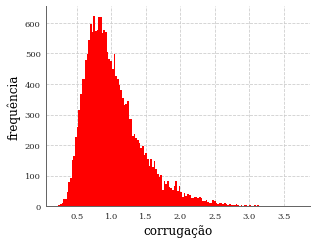

In [4]:
histograma(df['std_oop'], legendas = ['corrugação', 'frequência'])

In [5]:
logic = df["std_oop"] <= 0.8
print(len(df.loc[logic]),'baixa')
logic = (df["std_oop"] > 0.8) & (df["std_oop"] <= 1.2)
print(len(df.loc[logic]),'media')
logic = (df["std_oop"] > 1.2)
print(len(df.loc[logic]),'alta')

6760 baixa
7957 media
5679 alta


In [6]:
df['oop_categorico'] = None

logic = df["std_oop"] <= 0.8
df.loc[logic, 'oop_categorico'] = 'baixa'
logic = (df["std_oop"] > 0.8) & (df["std_oop"] <= 1.2)
df.loc[logic, 'oop_categorico'] = 'media'
logic = (df["std_oop"] > 1.2)
df.loc[logic, 'oop_categorico'] = 'alta'
print(df)

         C    H    O  atom_number_total  C_concentration  H_concentration  \
0      232   72   40                344         0.674419         0.209302   
1      232   71   39                342         0.678363         0.207602   
2      232   72   40                344         0.674419         0.209302   
3      232   72   40                344         0.674419         0.209302   
4      232   72   40                344         0.674419         0.209302   
...    ...  ...  ...                ...              ...              ...   
20391  576  166  300               1042         0.552783         0.159309   
20392  576  166  300               1042         0.552783         0.159309   
20393  576  166  300               1042         0.552783         0.159309   
20394  576  164  298               1038         0.554913         0.157996   
20395  576  166  300               1042         0.552783         0.159309   

       O_concentration  avg_diameter  max_diameter  min_diameter  ...  \
0 

In [7]:
del df['std_oop']

## Classificação com k-NN

In [8]:
#separando teste e treino
import seaborn as sns
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
FEATURES = df.columns.drop('oop_categorico')

TARGET = ["oop_categorico"]

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

In [9]:
#treinando o modelo classificador
from sklearn.neighbors import KNeighborsClassifier

# cria o modelo
modelo_knn = KNeighborsClassifier()

# treina o modelo
modelo_knn.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_knn.predict(X_teste)
print(previsao)

['baixa' 'media' 'media' ... 'baixa' 'baixa' 'baixa']


In [10]:
#calculando a acurácia da predição
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_teste, previsao))

Accuracy: 0.5553921568627451


## Classificação com Árvore de Decisão

In [11]:
from sklearn.tree import DecisionTreeClassifier

# cria o modelo
modelo_dt = DecisionTreeClassifier(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_dt.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(X_teste)
print(y_teste)
print(previsao)



['baixa' 'media' 'media' ... 'baixa' 'baixa' 'alta']
['baixa' 'media' 'media' ... 'baixa' 'baixa' 'media']


In [12]:
#calculando a acurácia da predição
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))

Accuracy: 0.5588235294117647


## Classificação com floresta aleatória

In [13]:
from sklearn.ensemble import RandomForestClassifier

# cria o modelo
modelo_rf = RandomForestClassifier(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_rf.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_rf.predict(X_teste)

importancia = modelo_rf.feature_importances_
desvio_padrao = np.std(
    [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
)

serie_importancia = pd.Series(importancia, index=FEATURES)

print(previsao)

['baixa' 'media' 'baixa' ... 'baixa' 'baixa' 'media']


In [14]:
print("Accuracy:",metrics.accuracy_score(y_teste, previsao))

Accuracy: 0.6651960784313725


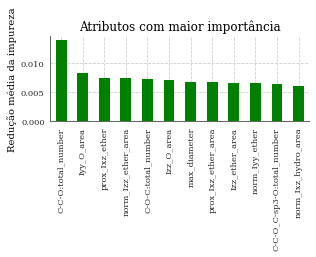

In [15]:
C = serie_importancia.sort_values(ascending = False)

fig, axe = plt.subplots()
C[0:12].plot.bar(ax=axe, color = 'g')
axe.set_ylabel("Redução média da impureza")
axe.set_title(f"Atributos com maior importância")
plt.show()

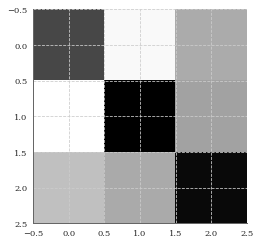

In [16]:
import sklearn
conf = sklearn.metrics.confusion_matrix(y_teste, previsao)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()